In [1]:
import stim
import numpy as np
import random

#### The steps to verify our protocol in this notebook

1. have functions to generate RGS with the XX measurement (or Y with Paul's)
2. Anchor one with half RGS
3. the question is, how to verify whether the logical measurement is correct?
4.


#### Steps to generate RGS

general idea is to do it like the generation from Paul (and Donovan's) with the bi-clique approach from us.

1. have one anchor qubits for each half (l_anchor and r_anchor)
2. each of the anchor
3. 


#### In order for the ABSA to figure out the measurement results and corrections

1. The ABSA needs to create the tree for each logical qubit (first-leaf) 

In [2]:
def xx_measurement_with_correction(
    target_1: int, target_2: int, neighbors_1: list[int], neighbors_2: list[int]
) -> stim.Circuit:
    circuit = stim.Circuit()
    circuit.append("H", [target_1, target_2])
    circuit.append("M", [target_1, target_2])
    for i in neighbors_1:
        circuit.append("CZ", [stim.target_rec(-1), i])
    for i in neighbors_2:
        circuit.append("CZ", [stim.target_rec(-2), i])
    return circuit

In [3]:
class Node:
    def __init__(self, qubit_index=-1, parent_index=-1):
        self.qubit_index = qubit_index
        self.parent_index = parent_index
        self.measurement_result: bool | None = (
            None  # this should be True and False if the qubit has been measured
        )
        self.children: list[Node] = []
        self.is_lost = False  # this is used to denote whether the qubit is lost in the fiber or not
        self.has_z = False  # this is used to denote whether the qubit has Z side effect from the emission process or not

    def get_post_order(self):
        return_list: list[Node] = []
        for u in self.children:
            return_list.extend(u.descendents_post_order())
        return [self] + return_list

    def get_level_traversal(self):
        return_list = [self]
        queue = [self]
        while len(queue) > 0:
            new_queue = []
            for u in queue:
                return_list.append(u)
                new_queue.extend(u.children)
            queue = new_queue
        return return_list

    def add_z_side_effects(self, circuit: stim.Circuit, z_prob=0.5):
        if len(self.children) == 0:
            return
        for u in self.children:
            u.add_z_side_effects(circuit, z_prob)
        if self.parent_index == -1:
            return
        if random.random() < z_prob:
            circuit.append("Z", self.qubit_index)
            self.has_z = not self.has_z

    def get_indices_from_level(self, k: int) -> list[int]:
        # Not that we need it right now?
        """get all the indices from the nodes"""
        cur_level = 0
        queue = [self]
        while len(queue) > 0:
            # arrive at the correct level, return the qubit indices
            if cur_level == k:
                return [v.qubit_index for v in queue]
            # need to go to the next level
            num_nodes_in_level = len(queue)
            for _ in range(num_nodes_in_level):
                u = queue.pop(0)
                queue.extend(u.children)
            cur_level += 1
        # should change this to an error
        return []  # empty list indicating the level specified is out of range

In [4]:
def count_total_nodes(bvec: list[int]) -> int:
    num_in_layers = bvec[:]
    for i in range(1, len(num_in_layers)):
        num_in_layers[i] *= num_in_layers[i-1]
    num_qubits_per_arm = 1 + np.sum(num_in_layers)
    return num_qubits_per_arm

def gen_rooted_logical_tree(root_index: int, starting_index: int, branching_vector: list[int]) -> tuple[Node, stim.Circuit, int]:
    # if the branching vector is [1] it is the physical qubit and not a logical qubit.
    num_total_nodes = count_total_nodes(branching_vector)
    circuit = stim.Circuit()
    circuit.append("H", [root_index] + [i for i in range(starting_index, starting_index + num_total_nodes - 1)])

    root = Node(root_index)
    cur_level = 0
    assigned_num = starting_index
    cur_nodes = [root]
    while cur_level < len(branching_vector):
        num_in_level = len(cur_nodes)
        for _ in range(num_in_level):
            u = cur_nodes.pop(0)
            u.children = [Node(assigned_num + i, u.qubit_index) for i in range(branching_vector[cur_level])]
            cz_targets = [[u.qubit_index, assigned_num + i] for i in range(branching_vector[cur_level])]
            circuit.append("CZ", [i for pair in cz_targets for i in pair])
            assigned_num += branching_vector[cur_level]
            cur_nodes.extend(u.children)
        cur_level += 1
    return root, circuit, assigned_num # the last one is the next index that isn't used in this tree

In [5]:
bv = [2, 3, 1]
root, circuit, idx = gen_rooted_logical_tree(0, 1, bv)
root.add_z_side_effects(circuit)
# circuit.diagram('timeline-svg')
circuit.diagram('timeline-svg')
circuit.diagram()

q0: -H-@-@-------------------------
        | |
 q1: -H-@-|-@-@-@-------------------
          | | | |
 q2: -H---@-|-|-|-@-@-@-----------Z-
            | | | | | |
 q3: -H-----@-|-|-|-|-|-@---------Z-
              | | | | | |
 q4: -H-------@-|-|-|-|-|-@---------
                | | | | | |
 q5: -H---------@-|-|-|-|-|-@-----Z-
                  | | | | | |
 q6: -H-----------@-|-|-|-|-|-@-----
                    | | | | | |
 q7: -H-------------@-|-|-|-|-|-@-Z-
                      | | | | | |
 q8: -H---------------@-|-|-|-|-|-@-
                        | | | | | |
 q9: -H-----------------@-|-|-|-|-|-
                          | | | | |
q10: -H-------------------@-|-|-|-|-
                            | | | |
q11: -H---------------------@-|-|-|-
                              | | |
q12: -H-----------------------@-|-|-
                                | |
q13: -H-------------------------@-|-
                                  |
q14: -H---------------------------@-

In [6]:
# helping functions for debugging purposes
def postorder_traversal(root: Node):
    for u in root.children:
        postorder_traversal(u)
    print(f'    {root.qubit_index}:{root.measurement_result}:{root.parent_index} -> {[u.qubit_index for u in root.children]}')

def get_all_indices(root: Node) -> list[int]:
    indices = []
    queue = [root]
    while len(queue) > 0:
        u = queue.pop(0)
        queue.extend(u.children)
        indices.append(u.qubit_index)
    return indices

In [7]:
def logical_z_measurement(s: stim.TableauSimulator, root: Node) -> stim.Circuit:
    # level traversal measuring Z -> X -> Z -> ...
    queue = root.children
    is_x_basis = False
    while len(queue) > 0:
        if is_x_basis:
            s.h(*[u.qubit_index for u in queue])
        new_queue: list[Node] = []
        for u in queue:
            u.measurement_result = s.measure(u.qubit_index)
            new_queue.extend(u.children)
        queue = new_queue
        is_x_basis = not is_x_basis


def get_z_result(root: Node) -> bool | None:
    # TODO: implement majority vote mechanism
    # direct result available
    if not root.is_lost and root.measurement_result is not None:
        return root.measurement_result
    # indirect measurement
    print('this should not happen')
    for u in root.children:
        if u.measurement_result is None:
            continue
        next_level_zs = [get_z_result(v) for v in u.children]
        if not all([z is not None for z in next_level_zs]):
            continue
        if u.has_z:
            next_level_zs.append(not u.measurement_result)
        else:
            next_level_zs.append(u.measurement_result)
        return next_level_zs.count(True) % 2 != 0
    # measurement result cannot be determined neither direct nor indirect
    return None


def logical_x_measurement(s: stim.TableauSimulator, root: Node):
    # this method accepts the Tableau simulator and perform inplace 
    # this method also modifies the Node
    # level traversal measuring X -> Z -> X -> ...
    queue = root.children
    is_x_basis = True
    while len(queue) > 0:
        if is_x_basis:
            # circuit.append("H", [u.qubit_index for u in queue])
            s.h(*[u.qubit_index for u in queue])
        new_queue: list[Node] = []
        for u in queue:
            # TODO: add loss probability here?
            u.measurement_result = s.measure(u.qubit_index)
            new_queue.extend(u.children)
        queue = new_queue
        is_x_basis = not is_x_basis

def decoding_logical_x_result(root: Node) -> bool:
    """The idea is that the logical X measurement result is
    determined by the parity of the X_i Z_children_of_i of any first level node i"""
    # TODO: implement the majority vote; currently get the result from the first successful measurement
    for u in root.children:
        if u.measurement_result is None:
            continue
        second_level_zs = [get_z_result(v) for v in u.children]
        if not all([z is not None for z in second_level_zs]):
            continue
        if u.has_z:
            second_level_zs.append(not u.measurement_result)
        else:
            second_level_zs.append(u.measurement_result)
        print(f'got result {second_level_zs.count(True) % 2 != 0}')
        return second_level_zs.count(True) % 2 != 0 # compute the parity

    # loigical measurement result cannot be determined
    return None

In [8]:
def generate_half_rgs(
    s: stim.TableauSimulator,
    m: int,
    branching_vector: list[int],
    anchor_index: int,
    starting_index: int,
) -> tuple[stim.Circuit, list[Node], list[int], list[bool], bool, int]:
    # TODO: might consider not having emitters and connect first level nodes with second leaf and anchor directly
    """return is the tuple indicating:
    1. stim circuit (might not need if we pass in Tableau simulator)
    2. list of root nodes [1...m]
    3. list of incides o f second leaf qubits [1...m]
    4. list of side effects on second leaf qubits [1...m]
    5. whether the anchor has Z side effect or not
    6. free qubit index for later usage
    """
    # if the set of emitters isn't specified, use the last index
    """
    1. in the process of the half RGS generation, using modified Paul's scheme with the two halfs
    instead of performing the emission process with emitters. We take a shortcut by creating the RGS tree
    ignoring the last layer (bottom most; leaf nodes) we randomly add Z side effects to it to simulate the
    emission process and also store them in the tree

    2. The side effect of the second leaf qubits is added by the XX measurement from the intermediate-anchors 
    """

    f"""
    General idea of this function:
    - given the stabilizer Tableau simulator, we create a half RGS anchored at {anchor_index}
    - The process of first-leaf qubit generation skips over the actual deterministic generation approach 
      and randomly add heralded Z side effects to physical qubits in the logical tree encoding (not including leaf nodes)
    - connecting hRGS anchor to the first-leaf qubits will require measurements, thus, done with Tableau simulator
    """

    # circuit to create all m logical first-leaf qubits
    circuit = stim.Circuit()
    circuit.append(
        "H", anchor_index
    )  # we assume that the anchor passed here is fresh in state |0>
    logical_roots: list[Node] = []
    second_leaf_z_side_effects = [False for _ in range(m)]
    circs: list[stim.Circuit] = []
    idx = starting_index
    for _ in range(m):
        r, circ, idx = gen_rooted_logical_tree(idx, idx + 1, branching_vector)
        logical_roots.append(r)
        circs.append(circ)
        circuit += circ
    # add random Z side effects
    for arm in range(m):
        logical_roots[arm].add_z_side_effects(circuit, 0.5)  

    # perform part of the circuit
    s.do(circuit)

    # now we want to use idx, idx + 1, idx + m - 1, and return idx + m to be used later
    second_leaf_qubit_indices = [idx + arm for arm in range(m)]
    second_leaf_anchor = idx + m
    has_z_on_anchor = False
    for arm in range(m):
        circ = stim.Circuit()
        circ.append("H", [second_leaf_anchor, idx + arm])
        circ.append(
            "CZ",
            [
                # connect second-leaf emitter w/ second-leaf
                idx + arm,  # this is the second leaf qubit
                second_leaf_anchor,
                # connect anchor with second-leaf emitter
                anchor_index,
                second_leaf_anchor,
                # connect second-leaf emitter with first-leaf anchor
                second_leaf_anchor,
                logical_roots[arm].qubit_index,
            ],
        )
        circ.append("H", [second_leaf_anchor, logical_roots[arm].qubit_index])
        circ.append("MR", [second_leaf_anchor, logical_roots[arm].qubit_index])

        s.do(circ)
        second_leaf_emitter_x_result, first_leaf_anchor_x_result = (
            s.current_measurement_record()[-2:]
        )
        if second_leaf_emitter_x_result:
            for v in logical_roots[arm].children:
                v.has_z = not v.has_z
        if first_leaf_anchor_x_result:
            has_z_on_anchor = not has_z_on_anchor
            second_leaf_z_side_effects[arm] = True

        # add to circuit for debugging purposes
        circuit += circ

    return (
        circuit,  # stim circuit (might not need if we pass in Tableau simulator)
        logical_roots,  # list of root nodes [1...m]
        second_leaf_qubit_indices,  # list of incides of second leaf qubits [1...m]
        second_leaf_z_side_effects,  # list of side effects on second leaf qubits [1...m]
        has_z_on_anchor,  # whether the anchor has Z side effect or not
        idx + m,  # free qubit index
    )

In [72]:
# simple test where we want to test this
m = 1
bv = [1]
mem_index = 0
free_index = 1

s = stim.TableauSimulator()
(circuit, roots, second_leaf_idx, second_leaf_eff, anchor_eff, free_index) = generate_half_rgs(s, m, bv, mem_index, free_index)

print(f"tick 0: {'Z' if anchor_eff else 'I'} {'Z' if roots[0].children[0].has_z else 'I'} {'Z' if second_leaf_eff[0] else 'I'}")

circ = stim.Circuit(
    """
SWAP 1 2
SWAP 2 3
"""
)
s.do(circ)
circuit += circ

queries = ['XZ_', 'ZXZ', '_ZX']
queries = [stim.PauliString(q) for q in queries]

if anchor_eff:
    p = stim.PauliString('Z__')
    # print(queries)
    # s.z(0)
    queries = [p * q * p for q in queries]

if roots[0].children[0].has_z:
    p = stim.PauliString('_Z_')
    # print(queries)
    # s.z(1)
    queries = [p * q * p for q in queries]

if second_leaf_eff[0]:
    p = stim.PauliString('__Z')
    # print(queries)
    # s.z(2)
    queries = [p * q * p for q in queries]

display(circuit.diagram())

for q in queries:
    print(q, s.peek_observable_expectation(q))
    assert s.peek_observable_expectation(q) == 1


print("------")
for p in s.canonical_stabilizers():
    print(p)

tick 0: I I I


q0: -H-----@-------------------------
           |
q1: -H-@---|-@-H-MR:rec[1]-SWAP------
       |   | |             |
q2: -H-@---|-|-------------SWAP-SWAP-
           | |                  |
q3: ---H-@-|-|------------------SWAP-
         | | |
q4: ---H-@-@-@-H-MR:rec[0]-----------

+XZ_ 1
+ZXZ 1
+_ZX 1
------
+X_X__
+ZXZ__
+_ZX__
+___Z_
+____Z


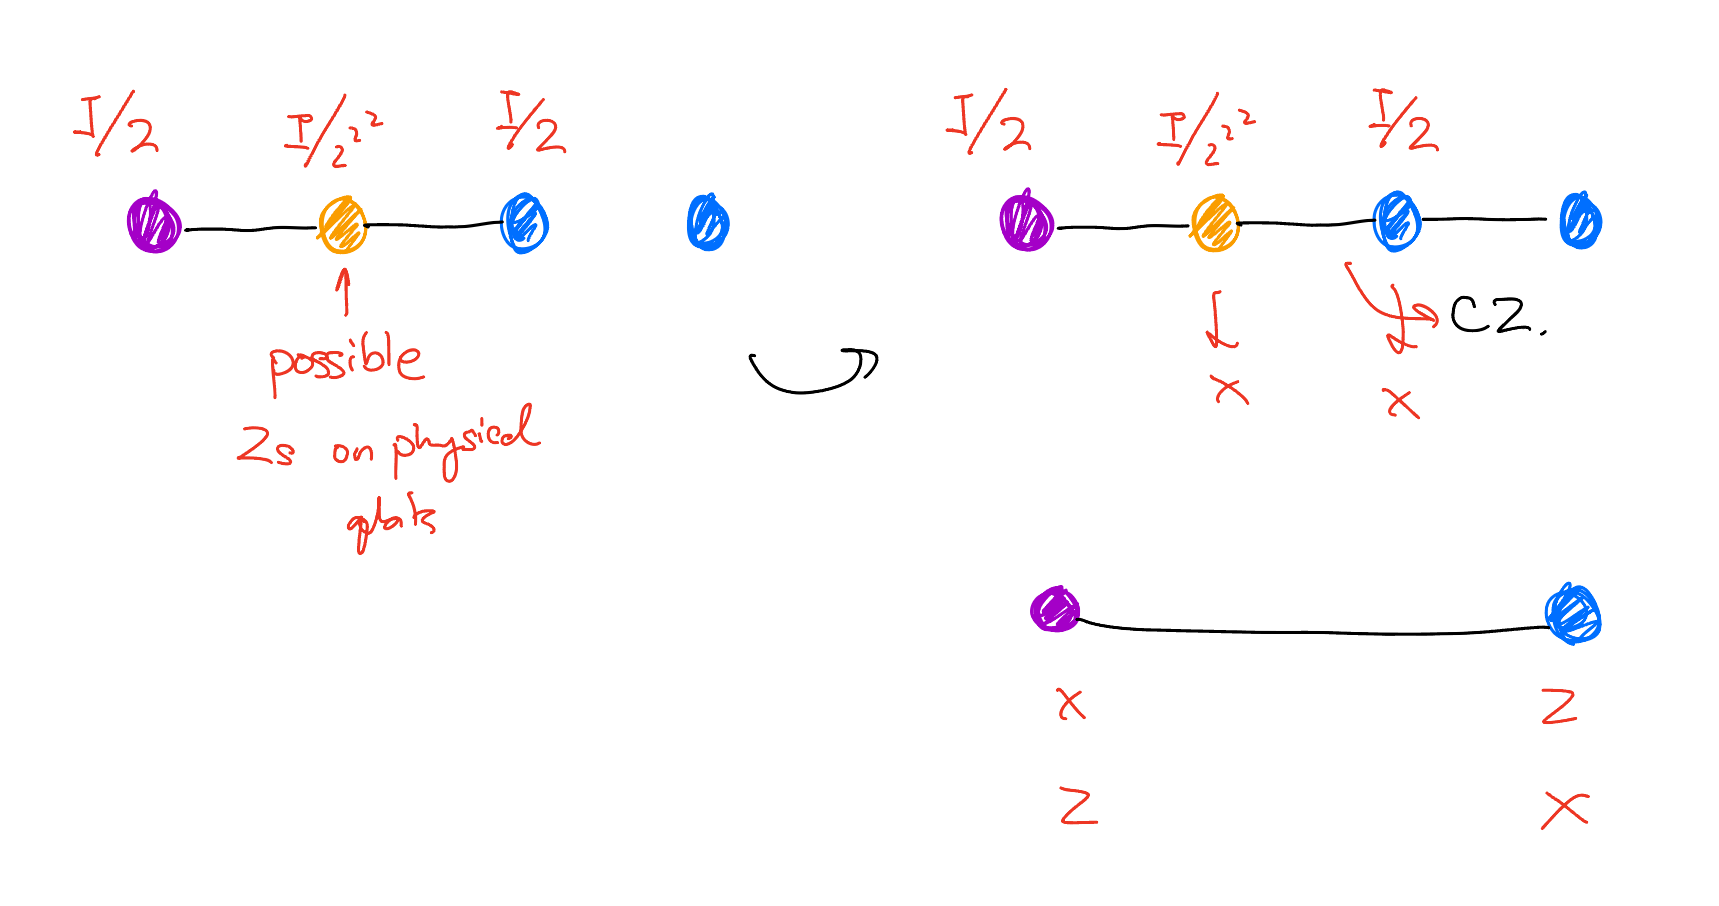

we want to test this first. To see if our gen_half RGS is functional or not

In [225]:
# simple test where we want to test this
m = 1
bv = [1]
mem_index = 0
free_index = 1

s = stim.TableauSimulator()
(circuit, roots, second_leaf_idx, second_leaf_eff, anchor_eff, free_index) = generate_half_rgs(s, m, bv, mem_index, free_index)

temp_circ = stim.Circuit()
temp_circ.append("H", free_index)
temp_circ.append("CZ", [free_index, second_leaf_idx[0]])
temp_circ.append("H", second_leaf_idx[0])
temp_circ.append("M", second_leaf_idx[0])

s.do(temp_circ)
slm = s.current_measurement_record()[-1]
logical_x_measurement(s, roots[0])
lxm = decoding_logical_x_result(roots[0])

print(f"tick 0: {'Z' if anchor_eff else 'I'} {'Z' if roots[0].has_z else 'I'} {'Z' if second_leaf_eff[0] else 'I'} {'I'}")

if second_leaf_eff[0]:
    slm = not slm

if slm:
    anchor_eff = not anchor_eff
if lxm:
    s.z(free_index)
if anchor_eff:
    s.z(anchor_eff)

for cs in s.canonical_stabilizers():
    print(cs)

circuit += temp_circ
display(circuit.diagram())

got result True
tick 0: Z I Z I
-X___Z
+Z___X
+_Z___
+__Z__
-___Z_


q0: -H-----@------------------------------
           |
q1: -H-@---|-@-H-MR:rec[1]----------------
       |   | |
q2: -H-@---|-|----------------------------
           | |
q3: ---H-@-|-|---------------@-H-M:rec[2]-
         | | |               |
q4: ---H-@-@-@-H-MR:rec[0]-H-@------------

In [108]:
# parameters for RGS
m = 1
# bv = [2, 3]
bv = [1]

left_memory_index = 0
right_memory_index = 1
free_index = 2
s = stim.TableauSimulator()

(
    left_circuit,
    left_roots,
    left_second_leaf_indices,
    left_second_leaf_side_effects,
    left_anchor_side_effect,
    free_index
) = generate_half_rgs(s, m, bv, left_memory_index, free_index)

(
    right_circuit,
    right_roots,
    right_second_leaf_indices,
    right_second_leaf_side_effects,
    right_anchor_side_effect,
    free_index,
) = generate_half_rgs(s, m, bv, right_memory_index, free_index)

circuit = left_circuit + right_circuit
s.cz(left_second_leaf_indices[0], right_second_leaf_indices[0])
print([left_second_leaf_indices[0], right_second_leaf_indices[0]])
s.h(left_second_leaf_indices[0], right_second_leaf_indices[0])
left_second_leaf_result, right_second_leaf_result = s.measure_many(left_second_leaf_indices[0], right_second_leaf_indices[0])

if left_second_leaf_side_effects[0]:
    left_second_leaf_result = not left_second_leaf_result

if right_second_leaf_side_effects[0]:
    right_second_leaf_result = not right_second_leaf_result

logical_x_measurement(s, right_roots[0])
left_correction = decoding_logical_x_result(right_roots[0]) ^ left_second_leaf_result
logical_x_measurement(s, left_roots[0])
right_correction = decoding_logical_x_result(left_roots[0]) ^ right_second_leaf_result

# don't forget the side effects

if left_correction:
    s.z(left_memory_index)
if right_correction:
    s.z(right_memory_index)

queries = ["XZ", "ZX"]

print(s.canonical_stabilizers()[:2])

for _ in range(1):
    for q in queries:
        print(q, s.peek_observable_expectation(stim.PauliString(q)))



# circuit.diagram('timeline-svg')

[4, 7]
[stim.PauliString("-XZ_______"), stim.PauliString("+ZX_______")]
XZ -1
ZX 1


In [9]:
bv = [2, 2]
# bv = [2,2,3]
# root = gen_logical_tree(bv)
root = gen_rooted_logical_tree(0, 1, bv)[0]
postorder_traversal(root)
print('total nodes: ', count_total_nodes(bv))
print(get_all_indices(root))
(gen_rooted_logical_tree(0, 1, bv)[1]).diagram()

    3:None:1 -> []
    4:None:1 -> []
    1:None:0 -> [3, 4]
    5:None:2 -> []
    6:None:2 -> []
    2:None:0 -> [5, 6]
    0:None:-1 -> [1, 2]
total nodes:  7
[0, 1, 2, 3, 4, 5, 6]


q0: -H-@-@---------
       | |
q1: -H-@-|-@-@-----
         | | |
q2: -H---@-|-|-@-@-
           | | | |
q3: -H-----@-|-|-|-
             | | |
q4: -H-------@-|-|-
               | |
q5: -H---------@-|-
                 |
q6: -H-----------@-

In [107]:
circuit = stim.Circuit(""" 
    H 0 1 2 3 4 5
    CZ 0 2 2 4 4 1 2 3 4 5
""")

circuit.append("H", [6, 7])
circuit.append("CZ", [3, 6, 5, 7])
circuit += xx_measurement_with_correction(2, 3, [0, 4], [6])
circuit += xx_measurement_with_correction(4, 5, [1, 6], [7])
circuit += xx_measurement_with_correction(6, 7, [0], [1])

s = stim.TableauSimulator()
s.do(circuit)
for e in s.canonical_stabilizers():
    print(repr(e))

queries = ["XZ", "ZX"]

for _ in range(1000):
    s = stim.TableauSimulator()
    s.do(circuit)
    for q in queries:
        assert s.peek_observable_expectation(stim.PauliString(q)) == 1


# circuit.diagram("timeline-svg")

stim.PauliString("+XZ______")
stim.PauliString("+ZX______")
stim.PauliString("-__Z_____")
stim.PauliString("+___Z____")
stim.PauliString("+____Z___")
stim.PauliString("-_____Z__")
stim.PauliString("-______Z_")
stim.PauliString("+_______Z")


In [111]:
circuit = stim.Circuit('''
H 0 1 2 4
CZ 0 2 2 4 1 4
''')

m = 14
hop_count = 5
bv = [10, 5]
# bv = [2, 2]
# bv = [1]

left_root, lcirc, idx = gen_rooted_logical_tree(3, 6, bv)
right_root, rcirc, idx = gen_rooted_logical_tree(5, idx, bv)
circuit = circuit + lcirc + rcirc
circuit.append("CZ", [2, 3, 4, 5])
circuit += xx_measurement_with_correction(2, 3, [0, 4], [u.qubit_index for u in left_root.children])
circuit += xx_measurement_with_correction(4, 5, [u.qubit_index for u in left_root.children] + [1], [u.qubit_index for u in right_root.children])

# circuit += logical_x_measurement(left_root)
# circuit += logical_x_measurement(right_root)

# print(f'decoded result: {decoding_logical_x_result(left_root)} {decoding_logical_x_result(right_root)}')

s = stim.TableauSimulator()
s.do(circuit)
logical_x_measurement(s, left_root)
logical_x_measurement(s, right_root)
print(f'decoded result: {decoding_logical_x_result(left_root)} {decoding_logical_x_result(right_root)}')
if decoding_logical_x_result(left_root):
    s.z(1)
if decoding_logical_x_result(right_root):
    s.z(0)

for e in s.canonical_stabilizers():
    print(repr(e))

postorder_traversal(left_root)

queries = ['XZ', 'ZX']
success_count = 0

for _ in range(1000 * m * hop_count * 2):
    s = stim.TableauSimulator()
    s.do(circuit)
    logical_x_measurement(s, left_root)
    logical_x_measurement(s, right_root)
    # print(f'decoded result: {decoding_logical_x_result(left_root)} {decoding_logical_x_result(right_root)}')
    if decoding_logical_x_result(left_root):
        s.z(1)
    if decoding_logical_x_result(right_root):
        s.z(0)

    if decoding_logical_x_result(left_root) is None or decoding_logical_x_result(right_root) is None:
        continue

    success_count += 1
    for q in queries:
        assert s.peek_observable_expectation(stim.PauliString(q)) == 1
        # print(q, s.peek_observable_expectation(stim.PauliString(q)))

print(f'success count: {success_count}')
# circuit.diagram('timeline-svg')

decoded result: True True
stim.PauliString("+XZ____________________________________________________________________________________________________________________________")
stim.PauliString("+ZX____________________________________________________________________________________________________________________________")
stim.PauliString("-__Z___________________________________________________________________________________________________________________________")
stim.PauliString("+___Z__________________________________________________________________________________________________________________________")
stim.PauliString("-____Z_________________________________________________________________________________________________________________________")
stim.PauliString("-_____Z________________________________________________________________________________________________________________________")
stim.PauliString("-______Z____________________________________________________________

In [69]:
class RGS:
    def __init__(self, m: int, branching_vector: list[int], starting_index: int):
        pass

In [ ]:
# generate one RGS'

left_anchor = 0
right_anchor = 1
branching_vector = [1] # physical one for now
num_nodes_in_first_leaf = count_total_nodes(branching_vector)
m = 2

circuit = stim.Circuit()
circuit += gen_rooted_logical_tree()


In [106]:
def generate_two_body_graph_state(starting_index: int = 0, num_pairs: int = 1) -> stim.Circuit:
    circuit = stim.Circuit()
    circuit.append("H", [i for i in range(starting_index, starting_index + (2 * num_pairs))])
    circuit.append("CZ", [i for i in range(starting_index, starting_index + (2 * num_pairs))])
    return circuit

# fc = generate_two_body_graph_state(0, 3)
# fc += generate_two_body_graph_state(2)
# fc += generate_two_body_graph_state(4)
# fc.diagram('timeline-svg')

circuit = generate_two_body_graph_state(0, 2)
circuit.append("CZ", [1, 2])

s = stim.TableauSimulator()
s.do(circuit)
# s.postselect_observable(stim.PauliString("+IXII"))
# s.postselect_observable(stim.PauliString("+IIXI"))
s.postselect_x([1, 2], desired_value=False)
for e in s.canonical_stabilizers():
    print(repr(e))
# queries = ['ZIIX', 'XIIZ']
# for q in queries:
#     print(q, s.peek_observable_expectation(stim.PauliString(q)))


stim.PauliString("+X__Z")
stim.PauliString("+Z__X")
stim.PauliString("+_X__")
stim.PauliString("+__X_")


In [105]:
def generate_two_body_graph_state(starting_index: int = 0, num_pairs: int = 1) -> stim.Circuit:
    circuit = stim.Circuit()
    circuit.append("H", [i for i in range(starting_index, starting_index + (2 * num_pairs))])
    circuit.append("CZ", [i for i in range(starting_index, starting_index + (2 * num_pairs))])
    return circuit

# fc = generate_two_body_graph_state(0, 3)
# fc += generate_two_body_graph_state(2)
# fc += generate_two_body_graph_state(4)
# fc.diagram('timeline-svg')

circuit = generate_two_body_graph_state(0, 2)
# circuit.append("CZ", [1, 2])

s = stim.TableauSimulator()
s.do(circuit)
s.postselect_observable(stim.PauliString("+IXXI"))
for e in s.canonical_stabilizers():
    print(repr(e))
# s.postselect_observable(stim.PauliString("+IIXI"))
# s.postselect_x([1, 2], desired_value=False)
# queries = ['ZIIZ', 'XIIX']
# for q in queries:
    # print(q, s.peek_observable_expectation(stim.PauliString(q)))


stim.PauliString("+XZZX")
stim.PauliString("+Z__Z")
stim.PauliString("+_X_Z")
stim.PauliString("+__XZ")


In [76]:
def generate_rgs(m: int, b_vec: list[int]) -> stim.Circuit:
    num_in_layers = b_vec[:]
    for i in range(1, len(num_in_layers)):
        num_in_layers[i] *= num_in_layers[i-1]
    num_qubits_per_arm = 1 + np.sum(num_in_layers)
    # physical rgs
    if len(b_vec) == 0:
        pass
    # logical qubits for first-leaf qubits
    raise NotImplementedError
    print(num_qubits_per_arm)
    # second_leaf_qubits = 
    pass

def assert_rgs(rgs_circ: stim.Circuit, m: int, b_vec: [int]) -> bool:
    pass

In [11]:
generate_rgs(1, [2, 3, 3])

27


In [28]:
circuit = stim.Circuit()
circuit.append("H", 0)
circuit.append("CNOT", [0, 1])
circuit.append("H", 0)
# circuit.append("H", 1)
circuit.append("M", [0, 1])

circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
# circuit.diagram()
# circuit.diagram('timeline-svg')

In [29]:
sampler = circuit.compile_sampler()
print(list(map(lambda x: '+1' if x[0] == x[1] else '-1', sampler.sample(shots=10))))

['+1', '+1', '+1', '-1', '-1', '-1', '-1', '+1', '-1', '+1']


In [35]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=5))

[[False]
 [False]
 [ True]
 [ True]
 [ True]]


In [46]:
s = stim.TableauSimulator()
s.do(stim.Circuit('''
    H 0
    CNOT 0 1
    HERALDED_ERASE(1) 0
'''))
s.postselect_observable(stim.PauliString("+IZ"))
queries = ['XX', 'YY', 'ZZ', '-ZZ', 'ZI', 'II', 'IIZ']
for q in queries:
    print(q, s.peek_observable_expectation(stim.PauliString(q)))

XX 0
YY 0
ZZ -1
-ZZ 1
ZI -1
II 1
IIZ 1


In [58]:
for _ in range(10):
    s = stim.TableauSimulator()
    s.do(stim.Circuit('''
        H 0
        CNOT 0 1
        HERALDED_ERASE(1) 0
    '''))
    s.postselect_observable(stim.PauliString("+IZ"))
    # queries = ['XX', 'YY', 'ZZ', '-ZZ', 'ZI', 'II', 'IIZ']
    queries = ['ZZ']
    for q in queries:
        print(q, s.peek_observable_expectation(stim.PauliString(q)))

ZZ 1
ZZ -1
ZZ 1
ZZ -1
ZZ -1
ZZ -1
ZZ -1
ZZ -1
ZZ -1
ZZ 1


In [41]:
class Node:
    def __init__(self, qubit_index=-1, parent_index=-1):
        self.qubit_index = qubit_index
        self.parent_index = parent_index
        self.children = []

def postorder_traversal(root: Node):
    for u in root.children:
        postorder_traversal(u)
    # print(root.qubit_index)
    print(f'    {root.qubit_index}:{root.parent_index} -> {[u.qubit_index for u in root.children]}')

In [42]:
class Node:
    def __init__(self, qubit_index=-1, parent_index=-1):
        self.qubit_index = qubit_index
        self.parent_index = parent_index
        self.children = []

def postorder_traversal(root: Node):
    for u in root.children:
        postorder_traversal(u)
    # print(root.qubit_index)
    print(f'    {root.qubit_index}:{root.parent_index} -> {[u.qubit_index for u in root.children]}')

def gen_logical_tree(bvec: list[int]):
    root = Node(0)
    cur_level = 0
    assigned_num = 1
    cur_nodes = [root]
    while cur_level < len(bvec):
        num_in_level = len(cur_nodes)
        for _ in range(num_in_level):
            u = cur_nodes.pop(0)
            u.children = [Node(assigned_num + i, u.qubit_index) for i in range(bvec[cur_level])]
            assigned_num += bvec[cur_level]
            cur_nodes.extend(u.children)
        cur_level += 1
    return root

def count_total_nodes(bvec: list[int]) -> int:
    num_in_layers = bvec[:]
    for i in range(1, len(num_in_layers)):
        num_in_layers[i] *= num_in_layers[i-1]
    num_qubits_per_arm = 1 + np.sum(num_in_layers)
    return num_qubits_per_arm

In [43]:
bv = [2,2,3]
root = gen_logical_tree(bv)
postorder_traversal(root)
print('total nodes: ', count_total_nodes(bv))


    7:3 -> []
    8:3 -> []
    9:3 -> []
    3:1 -> [7, 8, 9]
    10:4 -> []
    11:4 -> []
    12:4 -> []
    4:1 -> [10, 11, 12]
    1:0 -> [3, 4]
    13:5 -> []
    14:5 -> []
    15:5 -> []
    5:2 -> [13, 14, 15]
    16:6 -> []
    17:6 -> []
    18:6 -> []
    6:2 -> [16, 17, 18]
    2:0 -> [5, 6]
    0:-1 -> [1, 2]
total nodes:  19


In [75]:
def gen_physical_half_rgs(m: int, start_index: int, root_index: int):
    circuit = stim.Circuit()
    circuit.append("H", root_index)
    circuit.append("H", [i for i in range(start_index, start_index + m)])
    circuit.append("CZ", [root_index if i % 2 == 0 else int(start_index + (i - 1) / 2) for i in range(2 * m)])
    return circuit

# assuming that the anchor index is unused
def gen_half_rgs(m: int, anchor_index: int, start_index: int, branching_vector: [int]) -> stim.Circuit:
    
    circuit = stim.Circuit(f'''
        H {anchor_index} 
''')
    circuit.append("H", anchor_index)


circuit = gen_physical_half_rgs(3, 0, 6)
circuit += gen_physical_half_rgs(3, 3, 7)
circuit.append("CZ", [6, 7])

circuit.append("H", [6, 7])
circuit.append("M", [6, 7])
for i in range(3):
    circuit.append("CZ", [stim.target_rec(-1), i])
for i in range(3, 6):
    circuit.append("CZ", [stim.target_rec(-2), i])

queries = ['X__ZZZ', '_X_ZZZ', '__XZZZ', 'ZZZX__', 'ZZZ_X_', 'ZZZ__X']

for _ in range(1000):
    s = stim.TableauSimulator()
    s.do(circuit)
    for q in queries:
        # print(q, s.peek_observable_expectation(stim.PauliString(q)))
        assert s.peek_observable_expectation(stim.PauliString(q)) == 1

circuit.diagram('timeline-svg')
circuit.diagram()

q0: -H-@-----------------Z^rec[1]-
       |
q1: -H-|-@---------------Z^rec[1]-
       | |
q2: -H-|-|-@-------------Z^rec[1]-
       | | |
q3: ---|-|-|-H-@---------Z^rec[0]-
       | | |   |
q4: ---|-|-|-H-|-@-------Z^rec[0]-
       | | |   | |
q5: ---|-|-|-H-|-|-@-----Z^rec[0]-
       | | |   | | |
q6: -H-@-@-@---|-|-|-@-H-M:rec[0]-
               | | | |
q7: -------H---@-@-@-@-H-M:rec[1]-

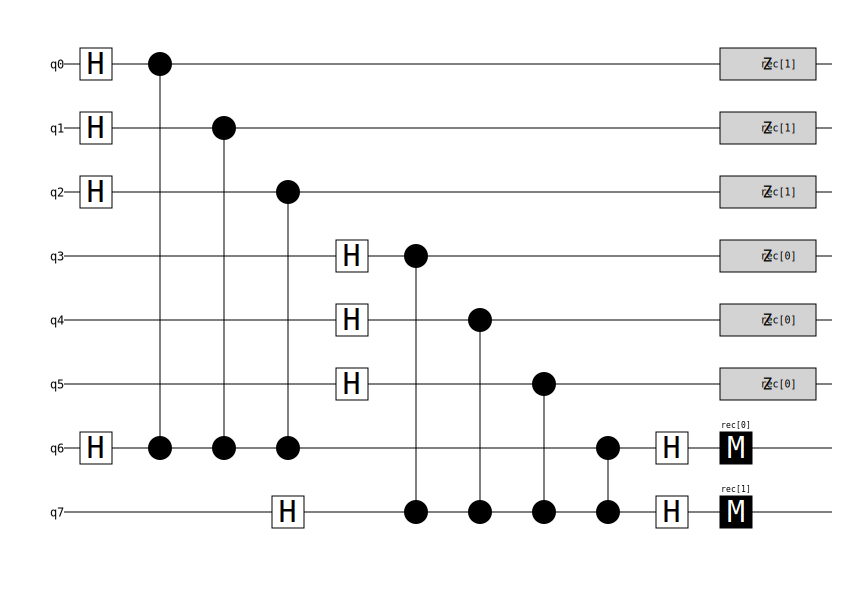

In [84]:
circuit = gen_physical_half_rgs(3, 0, 6)
circuit += gen_physical_half_rgs(3, 3, 7)
circuit.append("CZ", [6, 7])

circuit = xx_measurement_with_correction(circuit, 6, 7, [0,1,2], [3,4,5])

queries = ['X__ZZZ', '_X_ZZZ', '__XZZZ', 'ZZZX__', 'ZZZ_X_', 'ZZZ__X']

for _ in range(1000):
    s = stim.TableauSimulator()
    s.do(circuit)
    for q in queries:
        assert s.peek_observable_expectation(stim.PauliString(q)) == 1

circuit.diagram('timeline-svg')
# circuit.diagram()

In [102]:
circuit = stim.Circuit('''
    H 0 1 2 3 4
    CZ 0 1 1 2 1 3 3 4
    H 1 3
    M 1 3
    CZ rec[-1] 2 rec[-1] 0
    CZ rec[-2] 4
''')

circuit.diagram()

queries = ['X___Z', 'Z_Z_X', '__X_Z']

for _ in range(1000):
    s = stim.TableauSimulator()
    s.do(circuit)
    for q in queries:
        assert s.peek_observable_expectation(stim.PauliString(q)) == 1

# circuit.diagram('timeline-svg')
# circuit.diagram()

In [110]:
a = 1
b = 2
c = [1, 2, 3]
s = f'''{a} {b} {' '.join(map(str, c))}'''
s

'1 2 1 2 3'

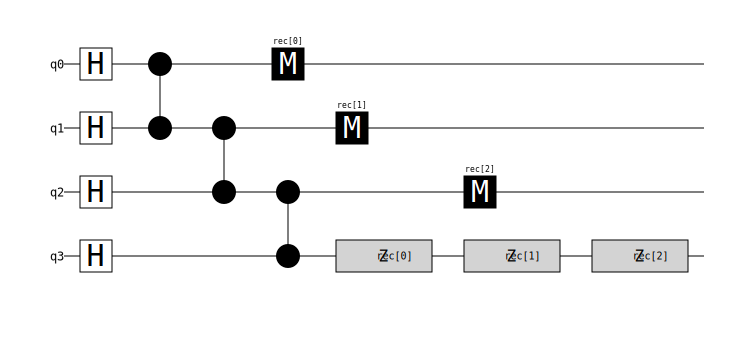

In [12]:
circuit = stim.Circuit('''
H 0 1 2 3
CZ 0 1 1 2 2 3
''')
for i in range(3):
    circuit.append("M", i)
    circuit.append("CZ", [stim.target_rec(-1), 3])
circuit.diagram("timeline-svg")

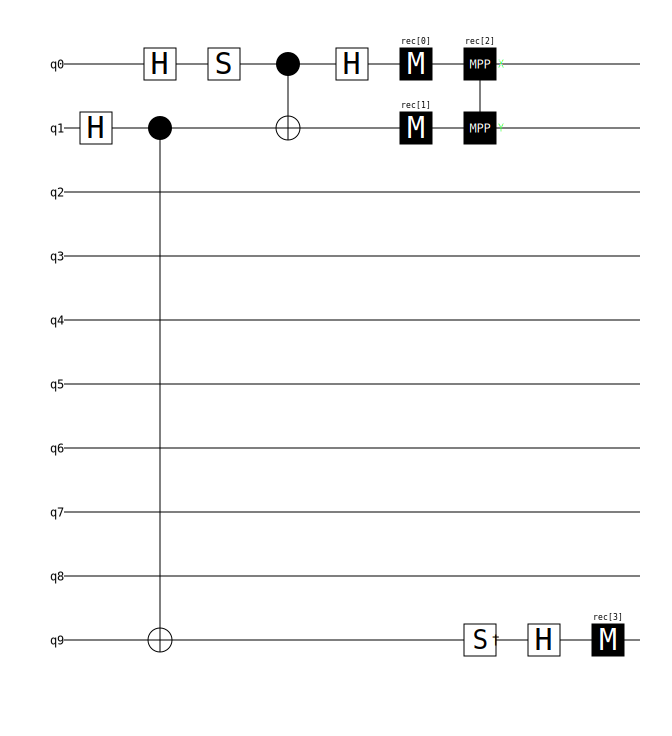

In [24]:
circuit = stim.Circuit(
    """
H 1 
CX 1 9 
H 0
S 0
CX 0 1
H 0
M 0 1
"""
)

circuit.append(
    "MPP",
    [
        stim.target_x(0),
        stim.target_combiner(),
        stim.target_y(1),
        # stim.target_combiner(),
        # stim.target_z(5),
    ],
)

# if stim.target_rec(-2):
#     circuit.append("Z", 9)
# if stim.target_rec(-1):
#     circuit.append("X", 9)

circuit.append("S_DAG", 9)
circuit.append("H", 9)
circuit.append("M", 9)

# s = stim.TableauSimulator()
# s.do(circuit)
circuit.diagram('timeline-svg')

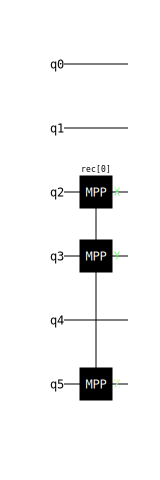

In [23]:
import stim

circuit = stim.Circuit()
circuit.append(
    "MPP",
    [
        stim.target_x(2),
        stim.target_combiner(),
        stim.target_y(3),
        stim.target_combiner(),
        stim.target_z(5),
    ],
)
circuit.diagram('timeline-svg')

In [25]:
a = [True, False, True]
print("".join("_!"[e] for e in a))


!_!


In [46]:
circuit = stim.Circuit(
    """
H 0 1
CZ 0 1
HERALDED_ERASE(0.5) 0
"""
)

s = stim.TableauSimulator()
s.do(circuit)
for e in s.canonical_stabilizers():
    print(repr(e))

# queries = ["XZ", "ZX"]

# for _ in range(1000):
#     s = stim.TableauSimulator()
#     s.do(circuit)
#     for q in queries:
#         assert s.peek_observable_expectation(stim.PauliString(q)) == 1


# circuit.diagram("timeline-svg")
circuit[0:1].diagram('timeline-svg')
circuit[0]

stim.PauliString("-XZ")
stim.PauliString("-ZX")


stim.CircuitInstruction('H', [stim.GateTarget(0), stim.GateTarget(1)], [])

In [113]:
a = range(10)
a[:-1]

range(0, 9)

In [118]:
ob = 251 - 11 - 20
nob = 11
# nob = 0

b = (ob * 304 + nob * 294)/10
a = (ob + nob) * 30

1500 + (a + b)/2

8470.7

In [119]:
14 * count_total_nodes([10, 5]) * 5

4270

In [16]:
circuit = stim.Circuit(
    """
H 0
CNOT 0 1 0 2
H 1 2
CNOT 0 3
H 0
M 0 1 2
"""
)

s = stim.TableauSimulator()
s.do(circuit)
for e in s.canonical_stabilizers():
    print(repr(e))

# queries = ["XZZ", "Z_X", "ZX_"] # with 3 qubits
queries = ["X__Z", "_X_Z", "__XZ", "ZZZX"] # with 3 qubits

for _ in range(1):
    s = stim.TableauSimulator()
    s.do(circuit)
    print(s.current_measurement_record())
    # for q in queries:
        # assert s.peek_observable_expectation(stim.PauliString(q)) == 1
        # print(q, s.peek_observable_expectation(stim.PauliString(q)))

stim.PauliString("-Z___")
stim.PauliString("-_Z__")
stim.PauliString("+__Z_")
stim.PauliString("+___X")
[True, False, True]


In [37]:
c1 = stim.Circuit("""
H 0
""")
c2 = stim.Circuit("""
CX 0 1
""")
c3 = stim.Circuit("""
MX 0 1
""")
s = stim.TableauSimulator()
s.do(c1)
s.do(c2)
s.do(c3)
a, b = s.current_measurement_record()[-2:]
print(a, b)
print(s.current_measurement_record()[-2:])
for e in s.canonical_stabilizers():
    print(repr(e))

False False
[False, False]
stim.PauliString("+X_")
stim.PauliString("+_X")


[stim.PauliString("+XX"), stim.PauliString("+ZZ")]
